In [8]:
import matplotlib.pyplot as plt
import numpy as np

import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
from time import time
import scipy.stats as stats
from scipy.stats import kstest, cramervonmises

# DATA PREPARATION
# the station-based rainfall data is already organized in a N by P matrix
rain_obs = np.loadtxt('data/sta_monthly.csv')
# read station lons (3rd column) and lats (4th column)
sta_loc = np.genfromtxt('data/sta_lookup_new.csv', delimiter=',')[:, 2:]

# the Kling-Gupta Efficiency (KGE) score
def kge(true_, fit):
    r = np.corrcoef(true_, fit)[0, 1]
    alpha = np.std(fit, ddof = 1) / np.std(true_, ddof= 1)
    beta = np.mean(fit) / np.mean(true_)
    return 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)

def nse(true_, fit):
    return 1 - np.sum((true_ - fit) ** 2) / np.sum((true_ - np.mean(true_)) ** 2)

rain_obs = rain_obs.T

sim_sel = np.loadtxt('data/wrf_loc.csv')
sim_idx = sim_sel[:, :2].astype(int)
sim_loc = sim_sel[:, 2:]

In [9]:
rf = np.zeros((14, 12 * 40))
zf = np.zeros((14, 12 * 40))
index_ = np.arange(14)
for i in range(12*40):
    t1 = time()
    data = np.concatenate((sta_loc, rain_obs[:, i][:, None]), axis=1)
    for j in range(14):
        mask = (index_ != j)
        OK = OrdinaryKriging(
            data[mask, 0],
            data[mask, 1],
            data[mask, 2],
            variogram_model="gaussian",
            verbose=False,
            enable_plotting=False,
        )
        tmp_rf, tmp_rsigma = OK.execute('points', [sta_loc[j, 0]], [sta_loc[j, 1]])
        rf[j, i] = tmp_rf.data[0]
        zf[j, i] = stats.norm.cdf(rain_obs[j, i], loc = tmp_rf.data[0], scale = np.sqrt(tmp_rsigma.data[0]))
    print(f'{i}th month, time: {time() - t1:.2f}s')

KeyboardInterrupt: 

In [5]:
tmp_rsigma

masked_array(data=[5251.57115150482],
             mask=[False],
       fill_value=1e+20)

In [6]:
KGE = np.zeros((12, 14))
KS_statistic = np.zeros((12, 14))
for i in range(12):
    for j in range(14):
        KGE[i, j] = kge(rain_obs[j, i::12], rf[j, i::12])
        KS_statistic[i, j] = kstest(zf[j, i::12], 'uniform').statistic
np.savetxt('kriging_kge.csv', KGE)
np.savetxt('kriging_ks.csv', KS_statistic)

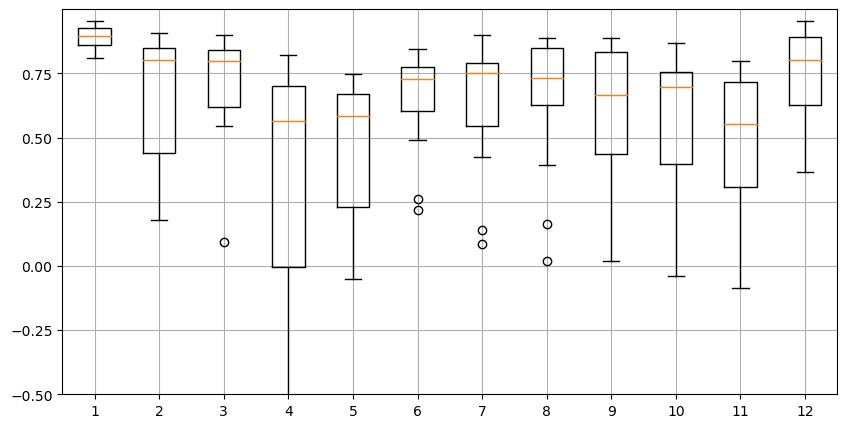

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_ylim(-0.5, 1)
ax.boxplot(KGE.T)
# set ytick gap at 0.25 
ax.set_yticks(np.arange(-0.5, 1, 0.25 ))
ax.grid()
